In [16]:
# Importing required libraries

import pandas as pd
import matplotlib.pyplot as plt

In [17]:
# Loading all data files

frem=pd.read_csv("Fremont_Hourly.csv")
bgt=pd.read_csv("Burke_Gilman_Trail_north_of_NE_70th_St_Bike_and_Ped_Counter.csv")
bct=pd.read_csv("Broadway_Cycle_Track_North_Of_E_Union_St.csv")
gwy=pd.read_csv("39th_Ave_NE_Greenway_at_NE_62nd_St.csv")


In [18]:
# Cleaning column names by converting to lower case and trimming

frem.columns = frem.columns.str.strip().str.lower().str.replace(' ','_')
bgt.columns = bgt.columns.str.strip().str.lower().str.replace(' ','_')
bct.columns = bct.columns.str.strip().str.lower().str.replace(' ','_')
gwy.columns = gwy.columns.str.strip().str.lower().str.replace(' ','_')


# Summing hourly counts in both directions for Fremont and BGT counters (The other counters have total counts)

frem['frem_total'] = frem.fremont_bridge_east_sidewalk + frem.fremont_bridge_west_sidewalk
bgt['bgt_total']=bgt.bike_north + bgt.bike_south

# Renaming total counts for Greenway and Broadway counters

bct.rename(columns={'broadway_cycle_track_north_of_e_union_st_total': 'bct_total'}, inplace=True)
gwy.rename(columns={'39th_ave_ne_greenway_at_ne_62nd_st_total': 'gwy_total'}, inplace=True)

# Retaining only total counts

bgt=bgt.drop(columns=['ped_south','ped_north','bgt_north_of_ne_70th_total','bike_south','bike_north'],axis=1)    
frem=frem.drop(columns=['fremont_bridge_east_sidewalk','fremont_bridge_west_sidewalk'],axis=1)
bct=bct.drop(columns=['nb','sb'],axis=1)
gwy=gwy.drop(columns=['north','south'],axis=1)




In [19]:
# Combining all bike counter data

df = frem.merge(bgt, how='outer', on=['date']).merge(bct, how='outer', on=['date']).merge(gwy, how='outer', on=['date'])


In [20]:
# Obtaining hour, day and weekday name for each record

df['date']=pd.to_datetime(df['date'])
df['hour']=df.date.dt.hour
df['weekday']=df.date.dt.weekday_name
df['day']=df.date.dt.dayofyear


In [21]:
# Deleting rows where there are missing values

df=df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31870 entries, 10920 to 48884
Data columns (total 8 columns):
date          31870 non-null datetime64[ns]
frem_total    31870 non-null float64
bgt_total     31870 non-null float64
bct_total     31870 non-null float64
gwy_total     31870 non-null float64
hour          31870 non-null int64
weekday       31870 non-null object
day           31870 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 2.2+ MB


The size of the combined dataframe was reduced from 53280 to 31870 records, while removing 'NA's. This is because all bike counters were installed at different points in time. For example, Fremont counter was set up in 2012 and has 53280 records, while Burke-Gilmann Trail counter was installed 2 years later, and has recorded bike counts for 39408 hours.

In [22]:
# Examining the dataframe
df.head()

,date,frem_total,bgt_total,bct_total,gwy_total,hour,weekday,day
10920,2014-01-01 00:00:00,23.0,13.0,2.0,0.0,0,Wednesday,1
10921,2014-01-01 01:00:00,27.0,8.0,13.0,5.0,1,Wednesday,1
10922,2014-01-01 02:00:00,19.0,9.0,2.0,0.0,2,Wednesday,1
10923,2014-01-01 03:00:00,13.0,19.0,0.0,0.0,3,Wednesday,1
10924,2014-01-01 04:00:00,6.0,19.0,0.0,0.0,4,Wednesday,1


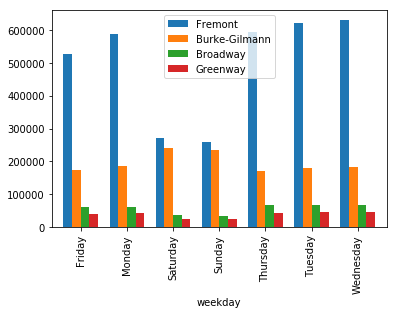

In [23]:
# Plot counts, group by weekday

counts_weekday=df.groupby('weekday')['frem_total','bgt_total','bct_total','gwy_total'].sum()
ax = counts_weekday.plot(kind='bar', width=0.75)
ax.legend (["Fremont", "Burke-Gilmann", "Broadway", "Greenway"])



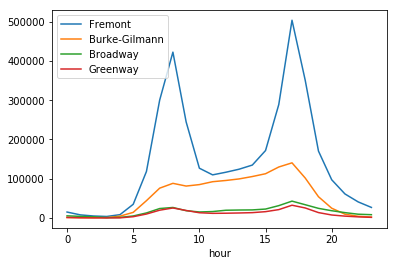

In [24]:
# Plot counts, group by hour

counts_hour=df.groupby('hour')['frem_total','bgt_total','bct_total','gwy_total'].sum()
ax = counts_hour.plot(kind='line')
ax.legend(["Fremont", "Burke-Gilmann", "Broadway", "Greenway"])



Fremont clearly has the most amount of bike traffic by a huge margin, followed by Burke-Gilmann Trail. The Broadway and Greenway tracks have much lower biking traffic, and are almost equal.

An interesting find is, during weekends Burke-Gilmann Trail counts are close to that of Fremont. But on weekdays, and especially during peak hours, Fremont bike counts seem to be extremely high, when related to the other counter numbers. Possibly, the Fremont lanes are relied on by people to get to work, while the other lanes are mostly used by biking enthusiasts for leisure. 

Since Fremont bike counts are the highest and we assume that Fremont trails are used mostly for commute, let's compare it to the other trails by first looking at scatter plots, and performing K-means cluster analysis.

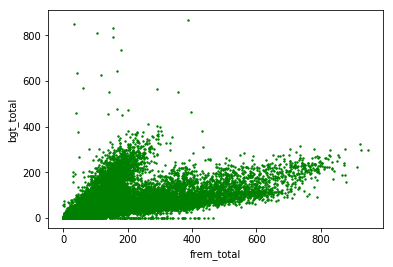

In [25]:
# df.plot(x='frem_total',y='bgt_total',kind='scatter',s=2, c=green)
df.plot(x='frem_total',y='bgt_total',kind='scatter',s=2, c='green')

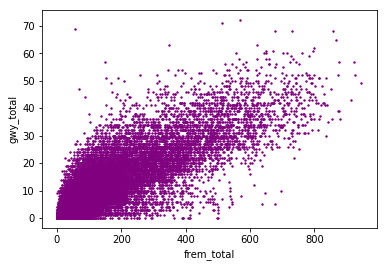

In [26]:
df.plot(x='frem_total',y='gwy_total',kind='scatter',s=2,c='purple')

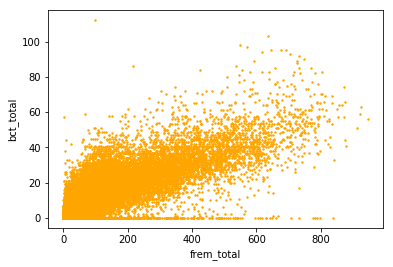

In [27]:
df.plot(x='frem_total',y='bct_total',kind='scatter',s=2,c='orange')

The scatter plot between Fremont (frem) and Broadway (bct) bike counts appear to be more spread out than the other two.
Next, we use elbow method to find optimum number of clusters.

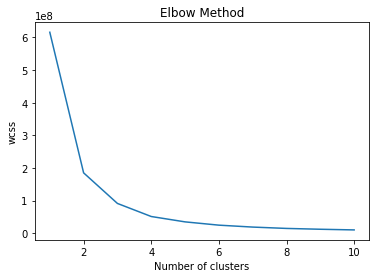

In [28]:
frem_bct=df[['frem_total','bct_total']]

# Elbow method to detemine number of clusters

from sklearn.cluster import KMeans
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(frem_bct)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

Possible number of clusters are 3 or 4. We perform K-means for both k=4 and then k=3.

In [29]:
# Fitting kmeans for k=4
    
km4=KMeans(n_clusters=4,init='k-means++', max_iter=300, n_init=10, random_state=0)
y_means = km4.fit_predict(frem_bct)

len(y_means)

31870

In [30]:
# Creating a new dataframe with hours, biking counts and y_means (Y)

type(y_means)
type(frem_bct)
# y_means is an array, cust is a dataframe.

# Converting y_means to a dataframe
y = pd.DataFrame(data=y_means, index=range(0,31870))
# During conversion, column name is 0. Let's change it to a meaningful name 'y'.
y.rename(columns={0:'y'}, inplace=True)
y

df2=frem_bct.join(y)
df2.head()

# Now our X values are in the first two columns, and y values (predicted cluster) are in the third column.

,frem_total,bct_total,y
10920,23.0,2.0,1.0
10921,27.0,13.0,3.0
10922,19.0,2.0,0.0
10923,13.0,0.0,0.0
10924,6.0,0.0,0.0


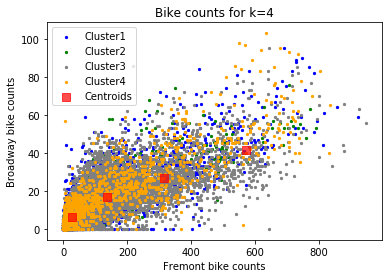

In [31]:
# Visualizing of clusters


plt.scatter(df2.frem_total[df2.y==0],df2.bct_total[df2.y==0],s=5, c='blue',label='Cluster1')
plt.scatter(df2.frem_total[df2.y==1],df2.bct_total[df2.y==1],s=5, c='green',label='Cluster2')
plt.scatter(df2.frem_total[df2.y==2],df2.bct_total[df2.y==2],s=5, c='grey',label='Cluster3')
plt.scatter(df2.frem_total[df2.y==3],df2.bct_total[df2.y==3],s=5, c='orange',label='Cluster4')



plt.scatter(km4.cluster_centers_[:,0], km4.cluster_centers_[:,1],s=50,marker='s', c='red', alpha=0.7, label='Centroids')
plt.title('Bike counts for k=4')
plt.xlabel('Fremont bike counts')
plt.ylabel('Broadway bike counts')
plt.legend()
plt.show()

In [32]:
# Fitting kmeans for k=3
    
km3=KMeans(n_clusters=3,init='k-means++', max_iter=300, n_init=10, random_state=0)
y_means = km3.fit_predict(frem_bct)

len(y_means)

31870

In [33]:
# Creating a new dataframe with hours, biking counts and y_means (Y)

type(y_means)
type(frem_bct)
# y_means is an array, cust is a dataframe.

# Converting y_means to a dataframe
y = pd.DataFrame(data=y_means, index=range(0,31870))
# During conversion, column name is 0. Let's change it to a meaningful name 'y'.
y.rename(columns={0:'y'}, inplace=True)
y

df2=frem_bct.join(y)
df2.head()

# Now our X values are in the first two columns, and y values (predicted cluster) are in the third column.

,frem_total,bct_total,y
10920,23.0,2.0,1.0
10921,27.0,13.0,0.0
10922,19.0,2.0,0.0
10923,13.0,0.0,2.0
10924,6.0,0.0,2.0


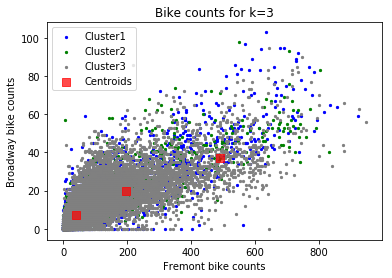

In [34]:
# Visualizing of clusters


plt.scatter(df2.frem_total[df2.y==0],df2.bct_total[df2.y==0],s=5, c='blue',label='Cluster1')
plt.scatter(df2.frem_total[df2.y==1],df2.bct_total[df2.y==1],s=5, c='green',label='Cluster2')
plt.scatter(df2.frem_total[df2.y==2],df2.bct_total[df2.y==2],s=5, c='grey',label='Cluster3')




plt.scatter(km3.cluster_centers_[:,0], km3.cluster_centers_[:,1],s=50,marker='s', c='red', alpha=0.7, label='Centroids')
plt.title('Bike counts for k=3')
plt.xlabel('Fremont bike counts')
plt.ylabel('Broadway bike counts')
plt.legend()
plt.show()

Cluster analysis gives better results for k=3. Most hours are plotted for the lower range of biking counts, possibly because it indicates counts for non-peak hours which constitutes for most of the day. To be noted that since Fremont bike counts are much bigger, the scale has been automatically set to 10x than the Broadway trail counts.